In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statistics import mean

### Model Schellinga

In [2]:
RASES = ['white', 'black']
SALARY = ['high', 'low']
COLORS = ['white', 'darkorange', 'navajowhite', 'darkcyan', 'mediumturquoise', 'purple', 'hotpink']

In [3]:
district = {(rase, salary): COLORS[2*i_r+i_s+1] for i_r, rase in enumerate(RASES) for i_s, salary in enumerate(SALARY) }
district

{('white', 'high'): 'darkorange',
 ('white', 'low'): 'navajowhite',
 ('black', 'high'): 'darkcyan',
 ('black', 'low'): 'mediumturquoise'}

In [4]:
N = 70
agents_ratio = 0.7   # [0.6, 0.7, 0.8] - params to test
n_agents = len(district)
a = 4
a_rase = 6
a_salary = 6
n_steps = 8000
cmap = ListedColormap(COLORS[:n_agents+1])

In [5]:
def create_city(a, N, agents_ratio, n_agents):
    empty_ratio = (1 - agents_ratio)
    indices = np.arange(-1, n_agents)
    prob = np.full(n_agents+1, agents_ratio/n_agents)
    prob[0] = empty_ratio
    city = np.random.choice(indices, size=N*N, p=prob)
    city = np.reshape(city, (N, N))
    return city

(array([-1,  0,  1,  2,  3]), array([1487,  879,  837,  813,  884], dtype=int64))


(-0.5, 69.5, 69.5, -0.5)

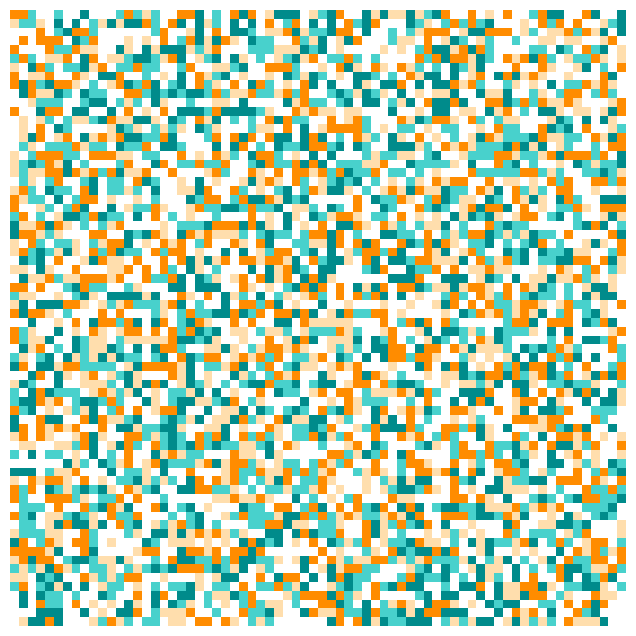

In [6]:
city = create_city(a, N, agents_ratio, n_agents)
print(np.unique(city, return_counts=True))
plt.figure(figsize=(8,8))
plt.imshow(city, cmap = cmap)
plt.axis('off')

Funkcja powiększająca automat komórkowy, poprzez dodanie do brzegów naprzeciwległego wiersza lub kolumny, w celu ułatwienia sprawdzania sąsiadów, przy założeniu, że automat komórkowy ma periodyczne warunki brzegowe. (np. mając macierz 10x10 po zastosowaniu funkcji otrzymujemy macierz 12x12)

In [7]:
def get_periodic_city(city):
    n = city.shape[0]
    first_col = city[:, 0]
    first_row = city[0, :]
    last_col = city[:, n-1]
    last_row = city[n-1, :]
    left_offset = np.insert(first_col, 0, city[n-1, 0])
    left_offset = np.insert(left_offset, left_offset.shape[0], city[0, 0])
    right_offset = np.insert(last_col, 0, city[n-1, n-1])
    right_offset = np.insert(right_offset, right_offset.shape[0], city[0, n-1])
    periodic_city =  np.concatenate(([last_row], city), axis=0)
    periodic_city =  np.concatenate((periodic_city, [first_row]), axis=0)
    periodic_city = np.concatenate((np.array([right_offset]).T, periodic_city), axis=1)
    periodic_city = np.concatenate((periodic_city, np.array([left_offset]).T), axis=1)
    return periodic_city

Funkcja zwracająca współrzęne nowej lokalizacji agenta z aktualizacją współrzędnych brzegowych, ze względu na periodyczne warunki brzegowe 

In [8]:
def choose_new_position(empty_houses, row, col, city_size):
    periodic_positions = {
        0: city_size-2,
        city_size-1: 1
    }
    random_house = random.choice(empty_houses)
    new_row = row + random_house[0] - 1
    if new_row in periodic_positions.keys():
        new_row = periodic_positions[new_row]
    new_col = col + random_house[1] - 1
    if new_col in periodic_positions.keys():
        new_col = periodic_positions[new_col]
    return new_row, new_col

Funkcja eliminująca migracje agentów, którzy wybrali to samo miejsce

In [9]:
def get_valid_moves(moves):
    positions = [pos for pos, _ in moves.items()]
    new_positions = [n_pos for _, n_pos in moves.items()]
    unique_pos, counts = np.unique(new_positions, return_counts=True, axis=0)
    same_pos = unique_pos[np.where(counts > 1)]
    same_pos = [tuple(new_pos) for new_pos in same_pos.tolist()]
    valid_moves = {pos:new_pos for pos, new_pos in moves.items() if new_pos not in same_pos} 
    return valid_moves   

Funkcja zwracająca listy obecnych ras oraz zarobków wewnątrz dystryktu

In [10]:
def get_district_features(district):
    district_features = list(district.keys())
    rases = np.array([district[0] for district in district_features])
    salary = np.array([district[1] for district in district_features])
    return rases, salary

In [11]:
def find_n_similar(neighborhood, value, rases, salaries):
    rase, salary = rases[value], salaries[value]
    same_rase_idx = np.where(rases == rase)[0]
    same_salary_idx = np.where(salaries == salary)[0]   
    n_similar = len(np.where(neighborhood == value)[0]) - 1
    n_similar_rase = 0
    n_similar_salary = 0
    for idx_r in same_rase_idx:
        if idx_r != value:
            n_similar_rase = len(np.where(neighborhood == idx_r)[0]) 
    for idx_s in same_salary_idx:
        if idx_s != value:
            n_similar_salary = len(np.where(neighborhood == idx_s)[0])  
    return n_similar, n_similar_rase, n_similar_salary

In [12]:
def schelling(city, district, n_steps):
    si = []
    average_si = []
    periodic_city = get_periodic_city(city)
    rases, salaries = get_district_features(district)
    for step in range(n_steps):  
        moves = {}
        for (row, col), _ in np.ndenumerate(periodic_city):
            n = periodic_city.shape[0]
            if row != 0 and col != 0 and row != n-1 and col != n-1:
                value = periodic_city[row, col]
                if value != -1:    # -1 -> empty space
                    neighborhood = periodic_city[
                        row - 1 : row + 2,
                        col - 1 : col + 2,
                    ]
                    n_similar, n_similar_rase, n_similar_salary = find_n_similar(neighborhood, value, rases, salaries)
                    si.append(n_similar)
                    if n_similar < a and n_similar_rase < a_rase and n_similar_salary < a_salary:
                        empty_houses = list(
                            zip(
                                np.where(neighborhood == -1)[0], np.where(neighborhood == -1)[1]
                            )
                        )
                        if len(empty_houses) != 0:
                            new_row, new_col = choose_new_position(empty_houses, row, col, n)
                            moves[(row, col)] = (new_row, new_col)

        valid_moves = get_valid_moves(moves)
        for pos, new_pos in valid_moves.items():
            value = periodic_city[pos[0], pos[1]]
            periodic_city[new_pos[0], new_pos[1]] = value
            periodic_city[pos[0], pos[1]] = -1

        segregated_city = periodic_city[1:n-1, 1:n-1]
        periodic_city = get_periodic_city(segregated_city)
        average_si.append(mean(si))
        if step%100 == 0: print(step, mean(si))

    return segregated_city, average_si

In [13]:
def plot_city(city, i, n, cmap):
    plt.subplot(9,3,3*i+n)
    plt.imshow(city, cmap = cmap)

0 1.4239444765760556
100 1.4062612739006695
200 1.4202901052861776
300 1.4283485355351067
400 1.439462362024378
500 1.4438318273805195
600 1.4514020877099956
700 1.457833929716203
800 1.461768076197408
900 1.4689686737119414
1000 1.4745474305913866
1100 1.4782223847188711
1200 1.4860847115547147
1300 1.4961801417159644
1400 1.506745367784475
1500 1.5190667181971225
1600 1.5327490156708736
1700 1.5474199676371774
1800 1.561732139685908
1900 1.5770324528595798
2000 1.591202663561221
2100 1.6068976490580238
2200 1.623022975255214
2300 1.6404907565272624
2400 1.659069902674541
2500 1.6787198365303966
2600 1.6986243890268657
2700 1.719262557041937
2800 1.7419755689170748
2900 1.7663421141350713
3000 1.792178970996558
3100 1.8216103725192474
3200 1.8532872444972281
3300 1.8858205682453517
3400 1.9205782533596334
3500 1.9578720712532105
3600 1.99619988599658
3700 2.0368926285534883
3800 2.079276723774709
3900 2.1231238034351945
4000 2.168592033599466
4100 2.215789036487454
4200 2.264317936914

Text(0, 0.5, 'average number of similar neighbours')

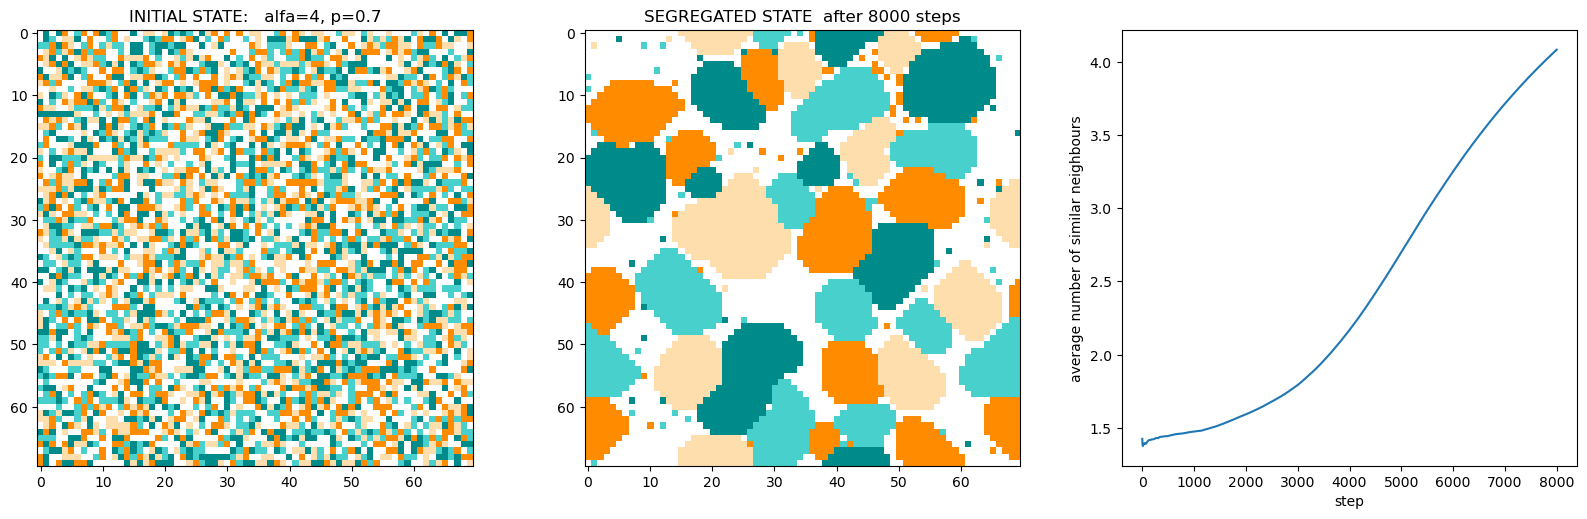

In [22]:
city = create_city(a, N, agents_ratio, n_agents)
plt.figure(figsize=(20,60))
segregated_city, average_si = schelling(city, district, n_steps)
plot_city(city, 0, 1, cmap)
plt.title(f'INITIAL STATE:   alfa={a}, p={agents_ratio}')
plot_city(segregated_city, 0, 2, cmap)
plt.title(f'SEGREGATED STATE  after {n_steps} steps')
plt.subplot(9,3,3)
plt.plot(np.arange(n_steps), average_si)
plt.xlabel('step')
plt.ylabel('average number of similar neighbours')

0 1.166269976198572
100 1.142758070434721
200 1.1474182978341885
300 1.1503759993041442
400 1.160117387591884
500 1.1657080263139141
600 1.1713470861496282
700 1.175777936119819
800 1.1785234454891262
900 1.1823366005733928
1000 1.186361411454917
1100 1.1903172319312818
1200 1.1952931663826558
1300 1.2016404612255214
1400 1.207221441138003
1500 1.2145895709105639
1600 1.2219993411971988
1700 1.2292575061852329
1800 1.2361722047576047
1900 1.2442768449326318
2000 1.253360059174765
2100 1.2644997824096005
2200 1.2769624514590368
2300 1.2890665486865327
2400 1.3008648074069784
2500 1.313911157740236
2600 1.3268490227060683
2700 1.3399731936526336
2800 1.3546313242914532
2900 1.3714367157100091
3000 1.3880824718860005
3100 1.4054184624827892
3200 1.4230596291260138
3300 1.4425987158744824
3400 1.4626847854917164
3500 1.4827457370949826
3600 1.5030389854493742
3700 1.5251400574442464
3800 1.5468242801224217
3900 1.5694344583002589
4000 1.5941030043407203
4100 1.6202808696197948
4200 1.64683

Text(0, 0.5, 'average number of similar neighbours')

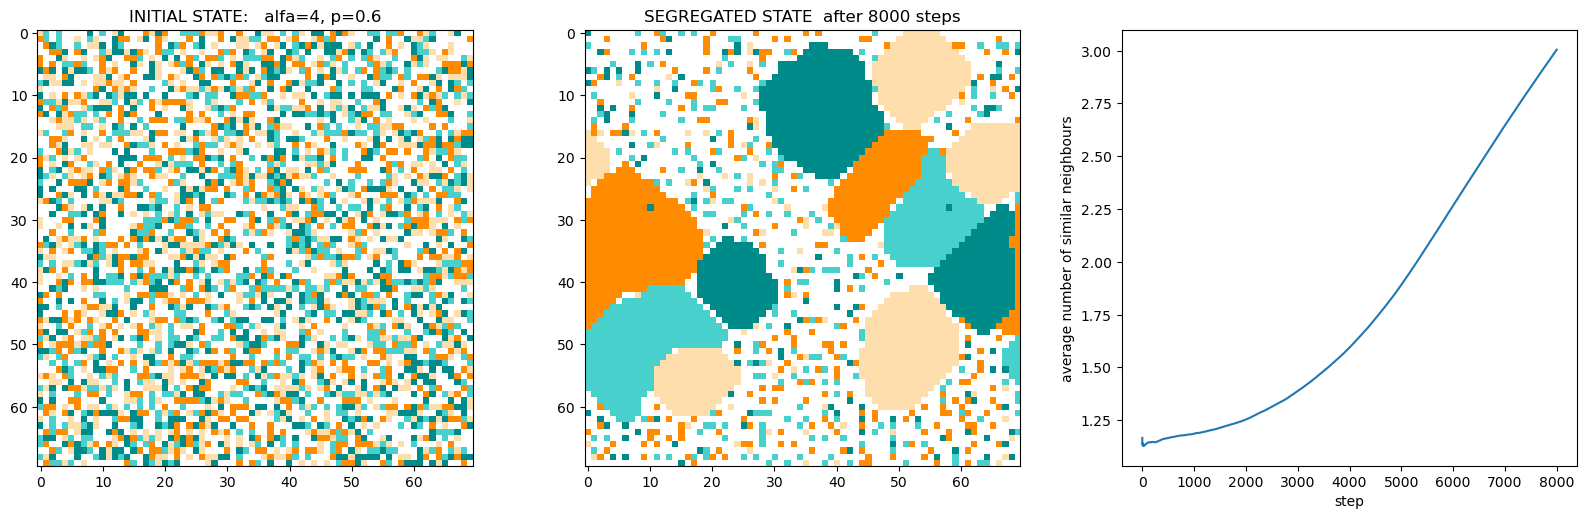

In [23]:
agents_ratio = 0.6
city = create_city(a, N, agents_ratio, n_agents)
plt.figure(figsize=(20,60))
segregated_city, average_si = schelling(city, district, n_steps)
plot_city(city, 0, 1, cmap)
plt.title(f'INITIAL STATE:   alfa={a}, p={agents_ratio}')
plot_city(segregated_city, 0, 2, cmap)
plt.title(f'SEGREGATED STATE  after {n_steps} steps')
plt.subplot(9,3,3)
plt.plot(np.arange(n_steps), average_si)
plt.xlabel('step')
plt.ylabel('average number of similar neighbours')

In [10]:
def show_experiments(algorithm, params, n_agents):
    cmap = cmap
    plt.figure(figsize=(25,60))
    for i, param in enumerate(params):
        a, size, agents_ratio, n_steps = param
        city = create_city(a, size, agents_ratio, n_agents)
        segregated_city, average_si = algorithm(city, n_steps)
        plot_city(city, i, 1, cmap)
        plt.title(f'INITIAL STATE: alfa={a}, p={agents_ratio}, city size={size}x{size}')
        plot_city(segregated_city, i, 2, cmap)
        plt.title(f'SEGREGATED STATE after {n_steps} steps')
        plt.subplot(9,3,3*i+3)
        plt.plot(np.arange(n_steps), average_si)
        plt.xlabel('step')
        plt.ylabel('average number of similar neighbours')

In [12]:
# (a, size, agents_ratio, n_steps)
params = [
    (4, 20, 0.35, 2000),
    (4, 20, 0.45, 2000),
    (4, 20, 0.55, 2000),
    (4, 20, 0.65, 2000),
    (4, 50, 0.45, 2000),
    (4, 50, 0.55, 2000),
    (4, 50, 0.65, 2000),
    (4, 100, 0.55, 2000),
    (4, 100, 0.65, 2000)
]

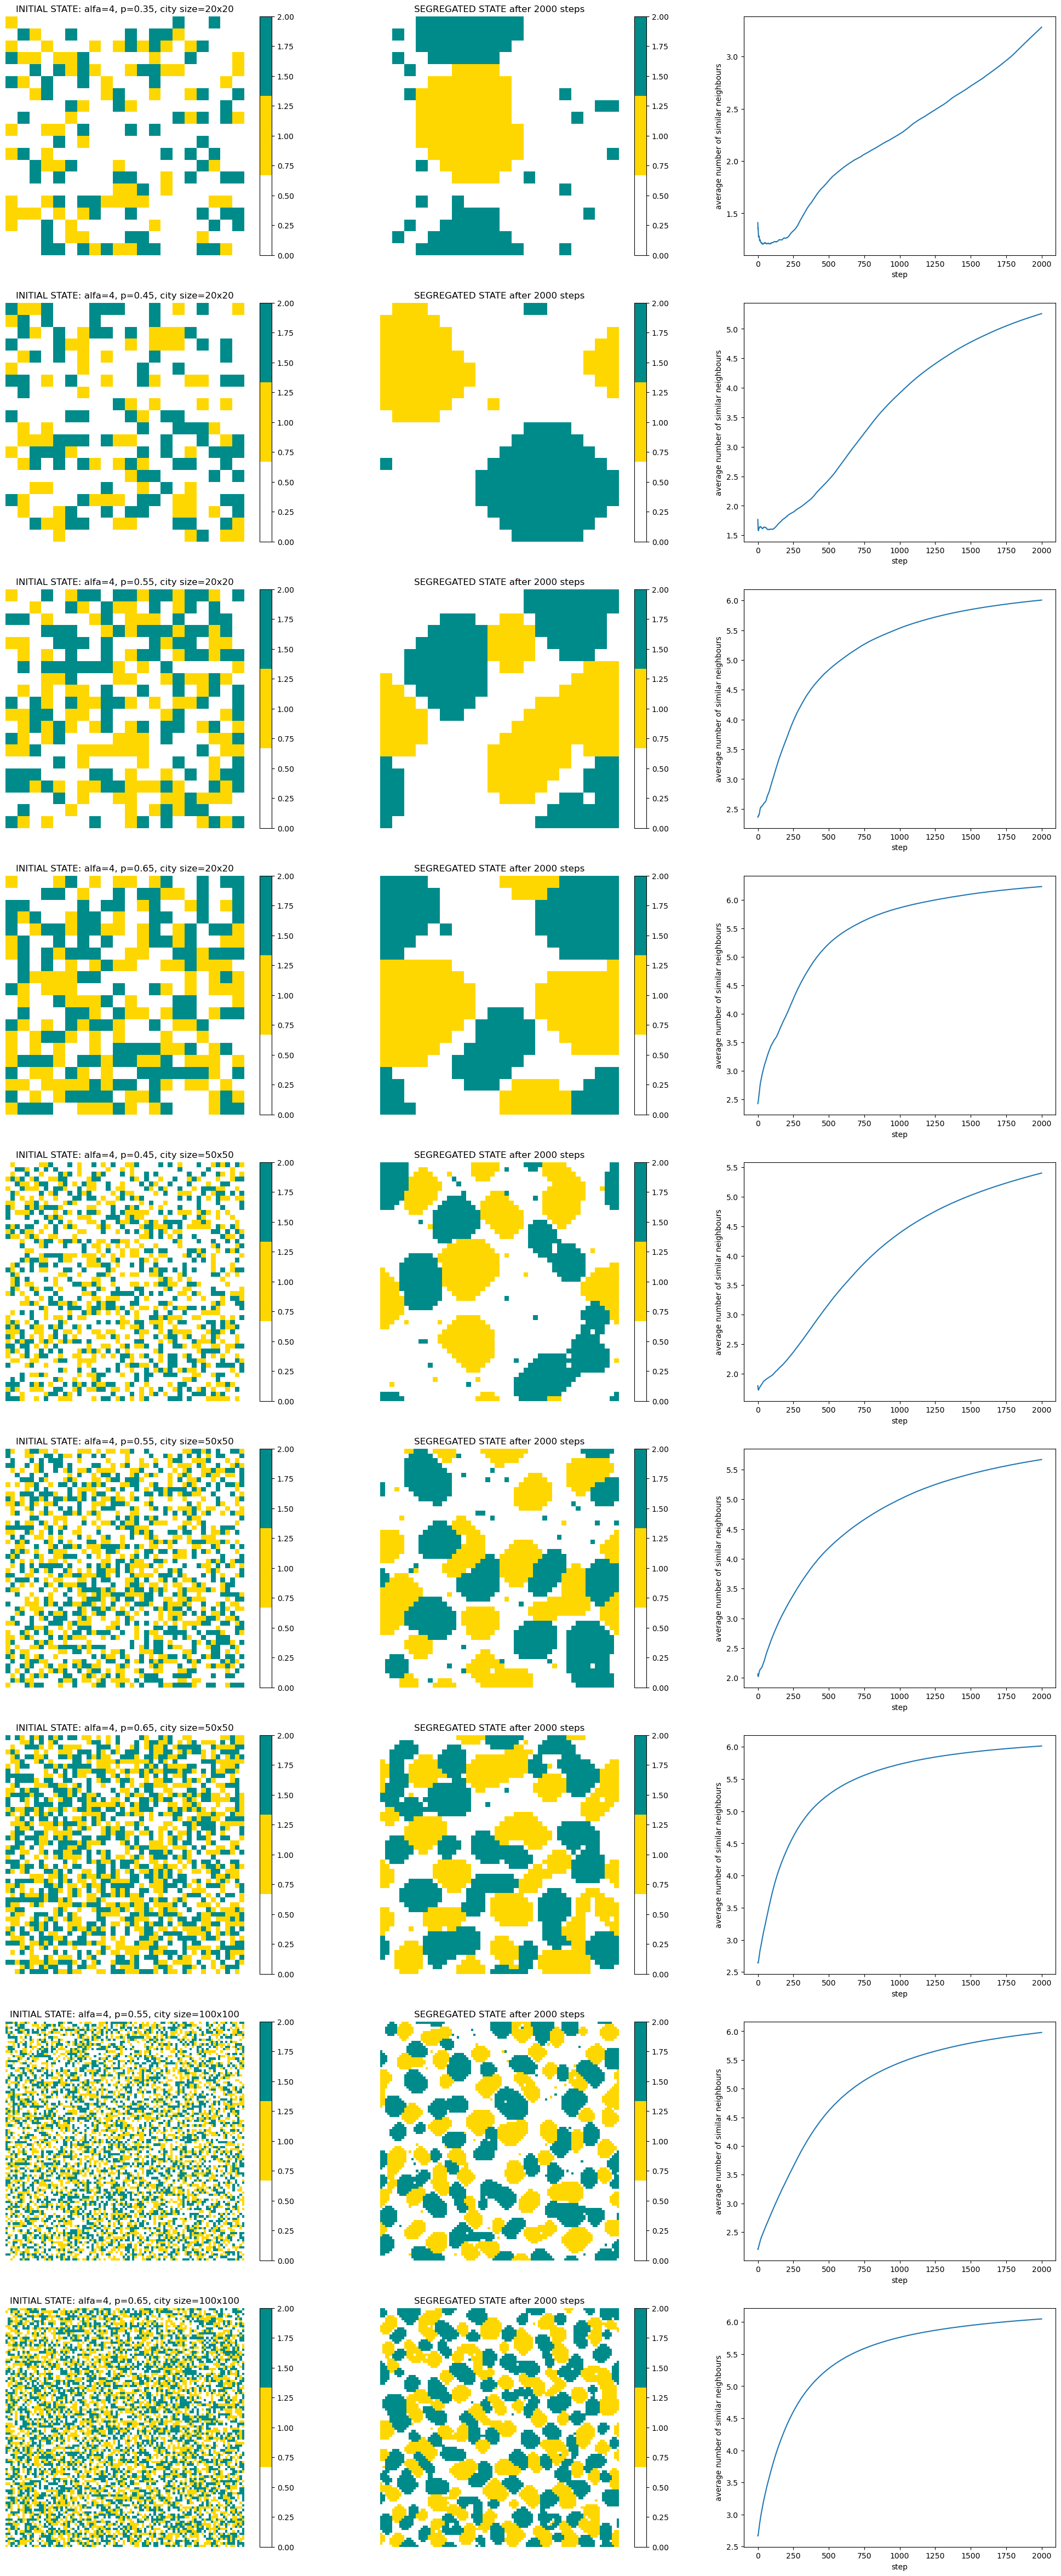

In [13]:
show_experiments(schelling, params, 2)

WNIOSKI:
1. Im większy procent pustych miejsc tym więcej kroków potrzeba, aby osiągnąć segregację przestrzenną.
2. Dla p=35% segregacja przestrzenna nie zachodzi 
3. Dla p=45% po 1000 krokach są widoczne klasry jednak nadal pozostaje sporo odseparowanych agentów. 
4. Dla p=55% po 1000 krokach klasry są już dobrze uformowane i jedynie kilka agentów nie należy do klastrów.
5. Dla p=65% zachodzi segregacja przestrzenna po około 1000 krokach.

In [14]:
params = [
    (4, 20, 0.65, 3000),
    (4, 20, 0.75, 3000),
    (4, 50, 0.65, 3000),
    (4, 50, 0.75, 3000),
    (4, 100, 0.65, 3000)
]

KeyboardInterrupt: 

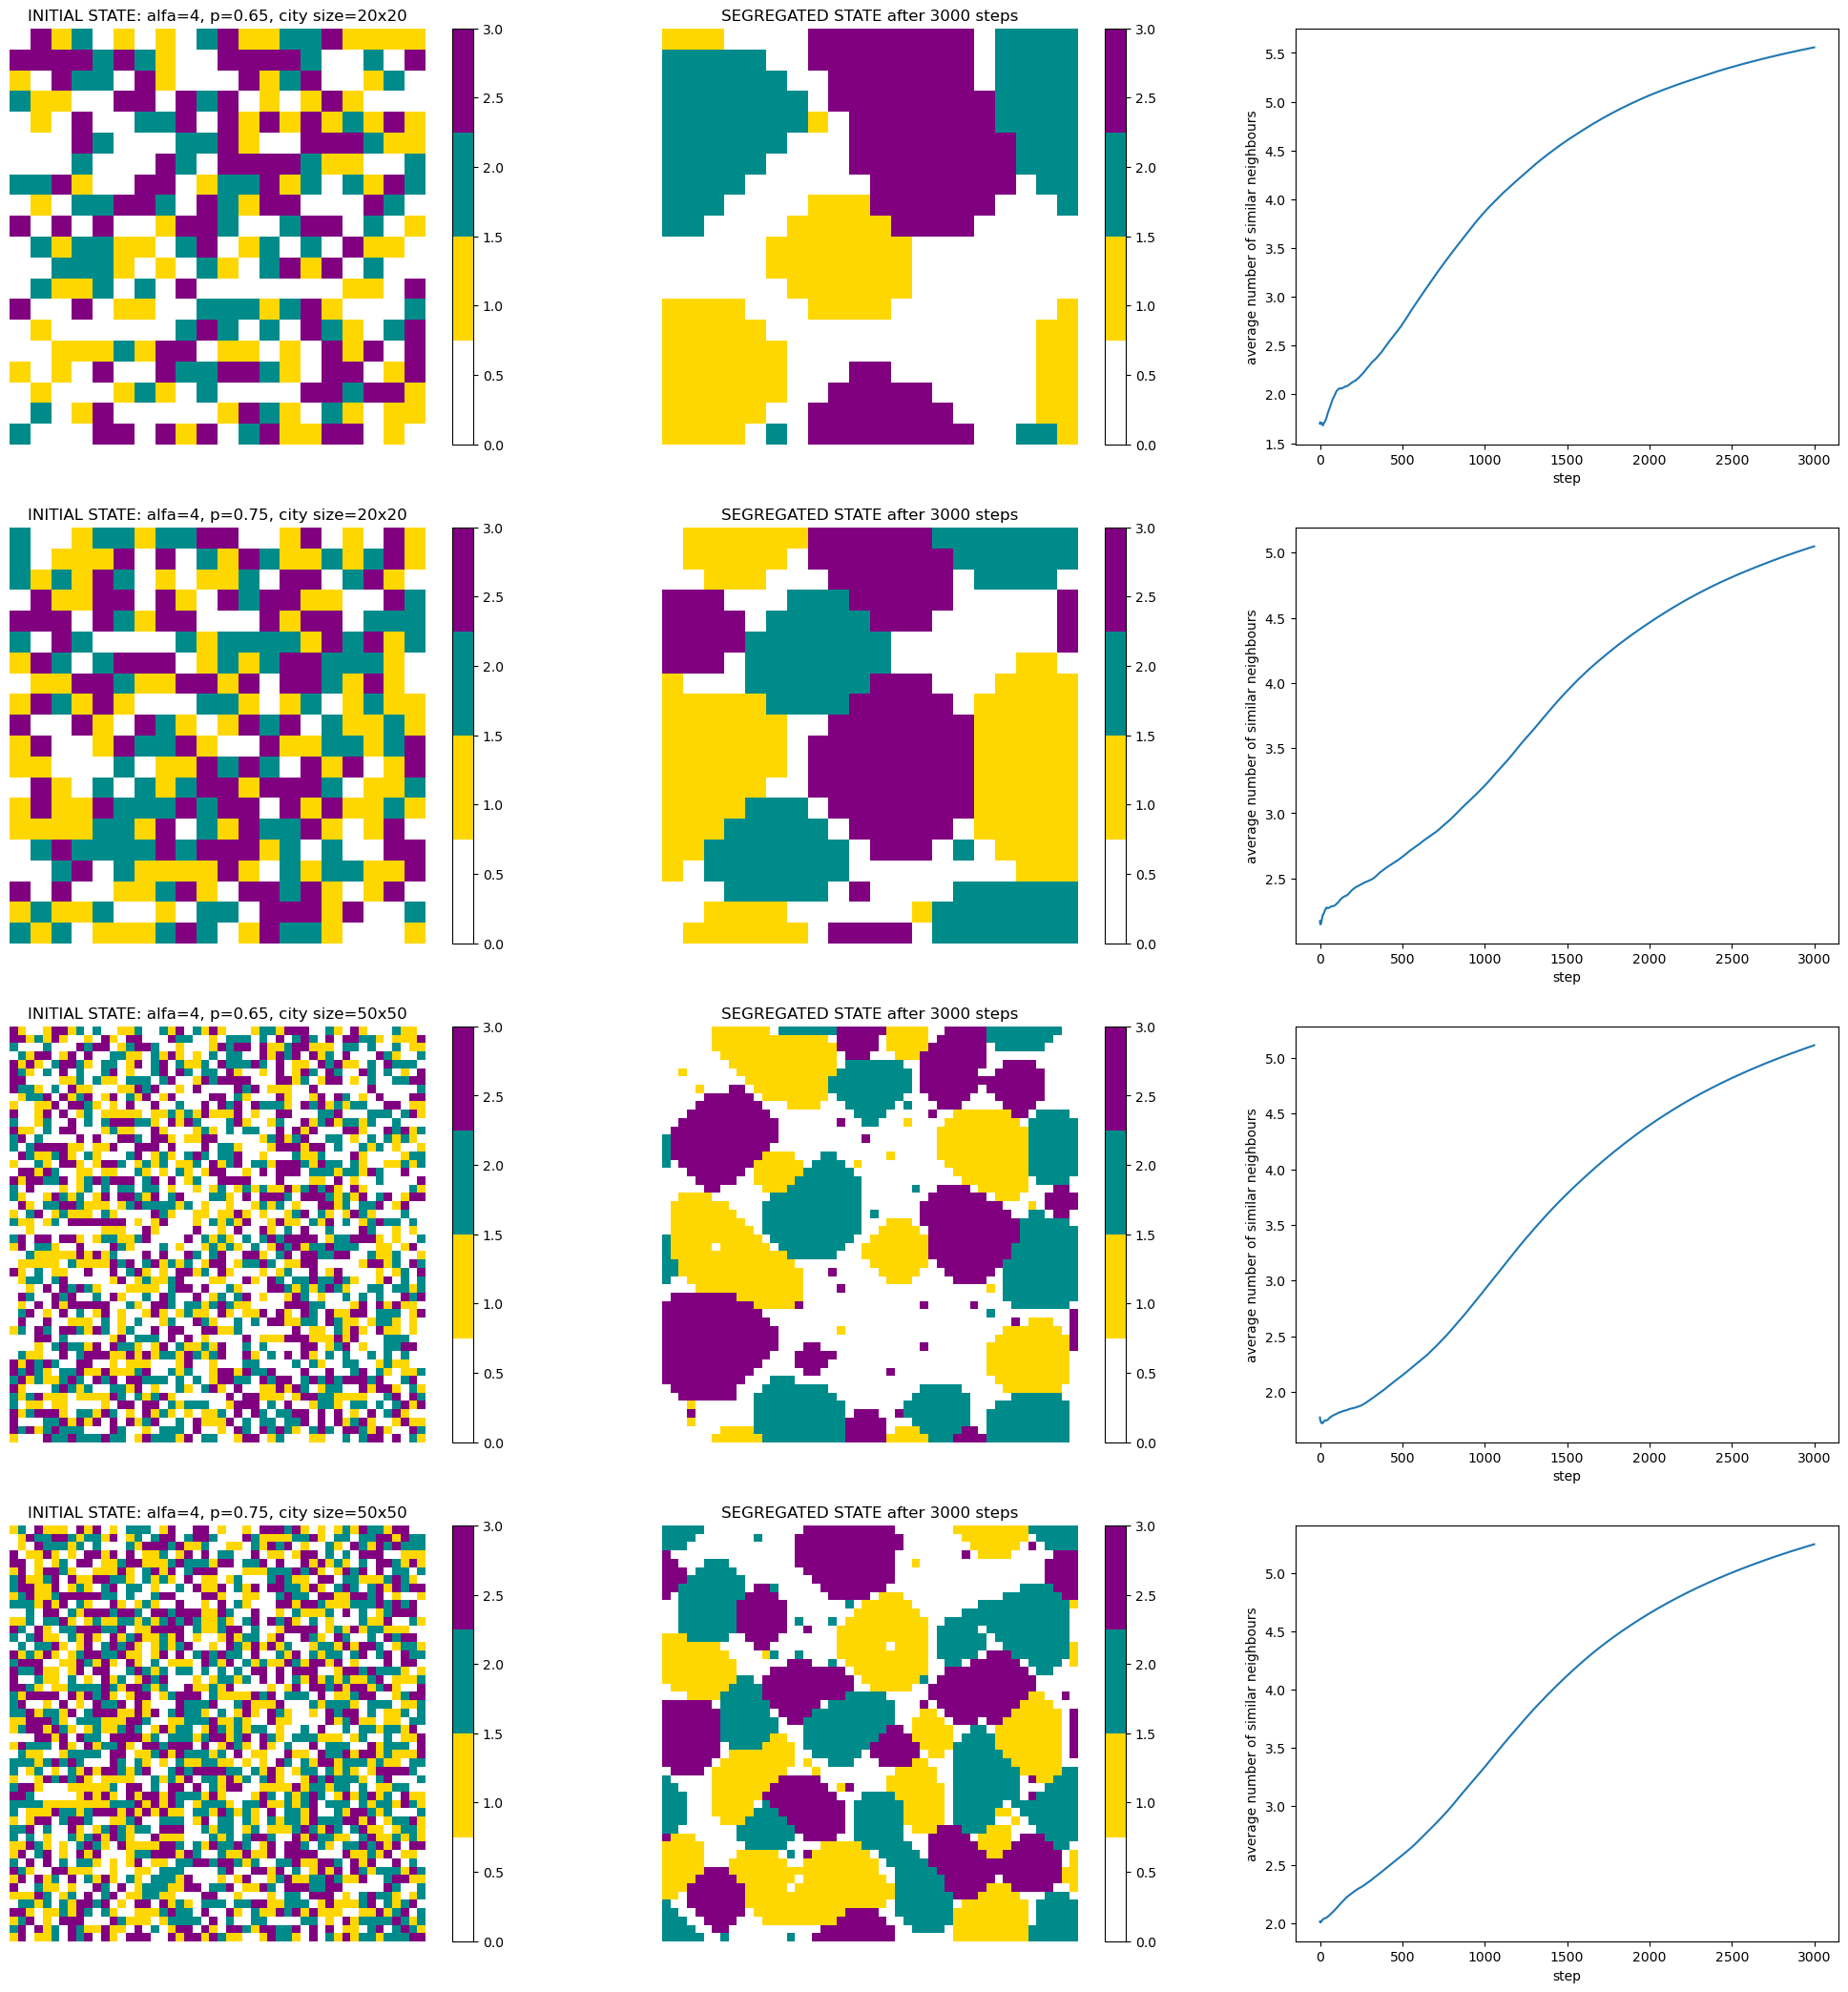

In [15]:
show_experiments(schelling, params, 3)

WNIOSKI:
1. Im więcej typów agentów tym trudniej osiągnąć segregację przestrzenną.
2. Dla p=35% oraz 45% po 2000 krokach nie uformowały się żadne klastry.
3. Dla p=55% oraz 65% powstało kilka klastrów, jednak nadal większość agentów jest nieposegregowana.
4. Aby doszło do segregacji przestrzennej prawdopodobnie potrzeba bardzo dużo iteracji algorytmu oraz niewielkiej ilości pustych miejsc.

### Model Gaylorda - D’Andria

In [291]:
def shorten_positions_list(agents_ready_to_move, empty_spaces_for_agent):
    n_agents = len(agents_ready_to_move)
    n_spaces = len(empty_spaces_for_agent)
    if n_agents > n_spaces:
        agents_ready_to_move = random.sample(agents_ready_to_move, n_spaces)
    elif n_agents < n_spaces:
        empty_spaces_for_agent = random.sample(empty_spaces_for_agent, n_agents)  
    return agents_ready_to_move, empty_spaces_for_agent

In [292]:
def get_valid_moves(agents_pos, empty_spaces, city_size):
    periodic_positions = {
        0: city_size-2,
        city_size-1: 1
    }
    np.random.shuffle(np.array(empty_spaces))
    moves = {pos: new_pos for pos, new_pos in zip(agents_pos, empty_spaces)}
    for pos, new_pos in moves.items():
        new_row, new_col = new_pos
        if new_row in periodic_positions.keys():
            new_row = periodic_positions[new_row]
        if new_col in periodic_positions.keys():
            new_col = periodic_positions[new_col]
        moves.update({pos: (new_row, new_col)})

    return moves

In [293]:
def change_position(city, moves):
    for pos, new_pos in moves.items():
        value = city[pos[0], pos[1]]
        city[new_pos[0], new_pos[1]] = value
        city[pos[0], pos[1]] = 0
    return city

In [294]:
def gaylord(city, n_steps):
    si = []
    average_si = []
    periodic_city = get_periodic_city(city)
    for _ in range(n_steps):
        agents_1_ready_to_move = []
        agents_2_ready_to_move = []
        empty_spaces_for_agent_1 = []
        empty_spaces_for_agent_2 = []
        for (row, col), _ in np.ndenumerate(periodic_city):
            n = periodic_city.shape[0]
            if row != 0 and col != 0 and row != n-1 and col != n-1:
                value = periodic_city[row, col]     
                neighborhood = periodic_city[
                    row - 1 : row + 2,
                    col - 1 : col + 2,
                ]
                if value != 0:
                    n_similar = len(np.where(neighborhood == value)[0]) - 1
                    si.append(n_similar)
                    if n_similar < a:
                        if value == 1:
                            agents_1_ready_to_move.append((row, col))
                        else:
                            agents_2_ready_to_move.append((row, col))
                else:
                    n_agents_1 = len(np.where(neighborhood == 1)[0]) 
                    if n_agents_1 >= a:
                        empty_spaces_for_agent_1.append((row, col))
                    n_agents_2 = len(np.where(neighborhood == 2)[0]) 
                    if n_agents_2 >= a:
                        empty_spaces_for_agent_2.append((row, col))

        agents_1_ready_to_move, empty_spaces_for_agent_1 = shorten_positions_list(agents_1_ready_to_move, empty_spaces_for_agent_1)
        agents_2_ready_to_move, empty_spaces_for_agent_2 = shorten_positions_list(agents_2_ready_to_move, empty_spaces_for_agent_2)

        valid_moves_1 = get_valid_moves(agents_1_ready_to_move, empty_spaces_for_agent_1, n)
        periodic_city = change_position(periodic_city, valid_moves_1)
        valid_moves_2 = get_valid_moves(agents_2_ready_to_move, empty_spaces_for_agent_2, n)
        periodic_city = change_position(periodic_city, valid_moves_2)

        segregated_city = periodic_city[1:n-1, 1:n-1]
        periodic_city = get_periodic_city(segregated_city)
        average_si.append(mean(si))

    return segregated_city, average_si

In [297]:
params = [
    (4, 20, 0.35, 500),
    (4, 20, 0.45, 500),
    (4, 20, 0.65, 500),
    (4, 20, 0.65, 500),
    (4, 50, 0.45, 500),
    (4, 50, 0.55, 500),
    (4, 50, 0.65, 500),
    (4, 100, 0.55, 500),
    (4, 100, 0.65, 500)
]

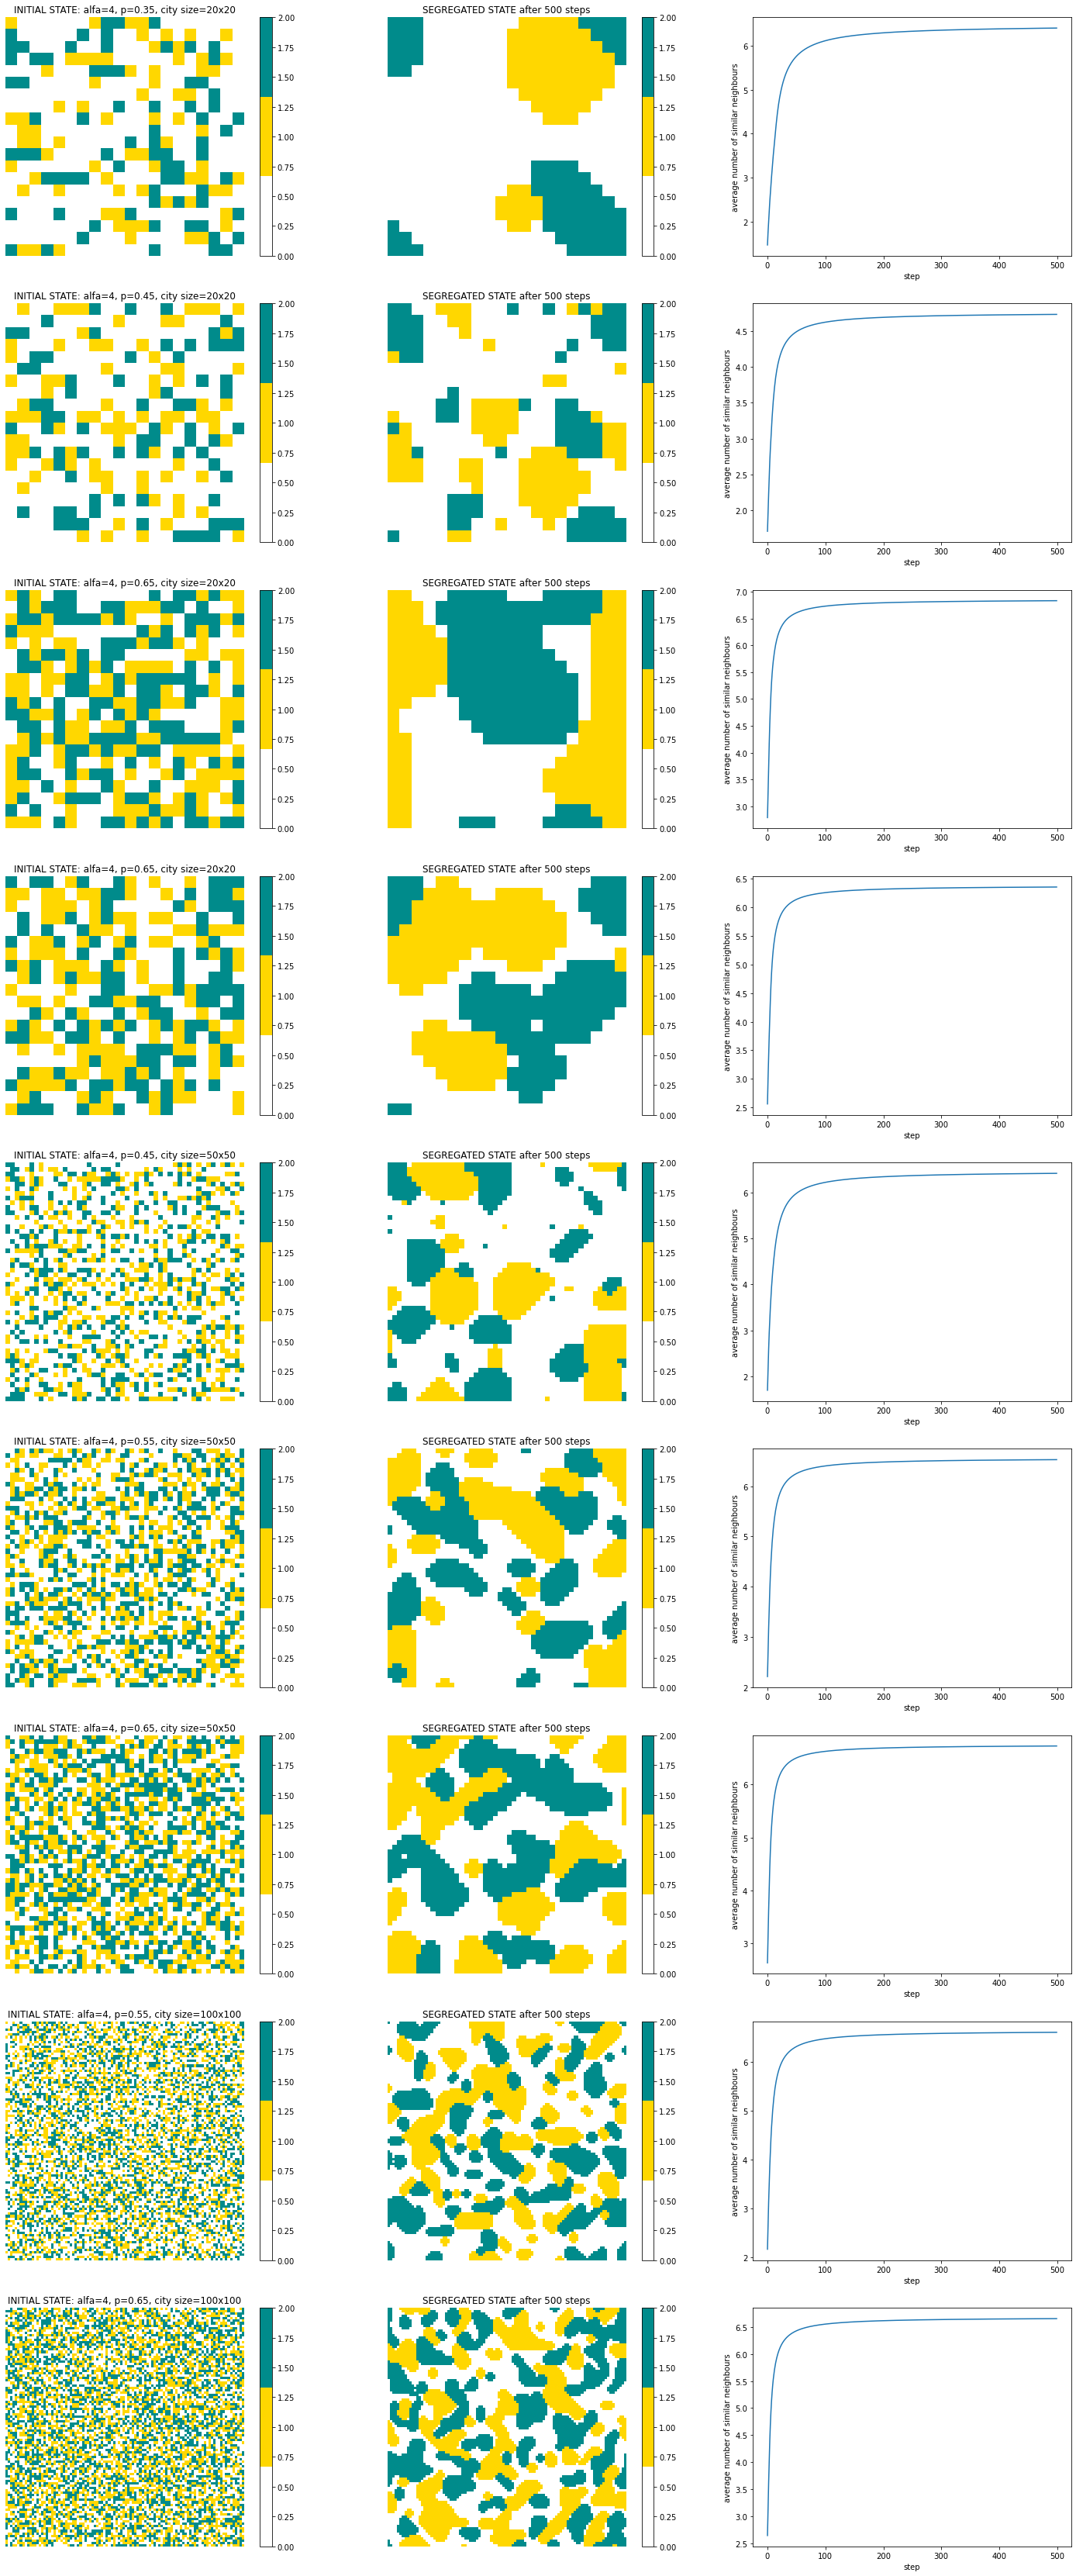

In [298]:
show_experiments(gaylord, params, 2)

WNIOSKI:
1. model Gaylorda-D’Andria działa znacznie szybciej oraz dokładniej od modelu Schellinga.
2. Wystarczy niewielka ilość iteracji (~100), aby osiągnąć segregację przestrzenną, nawet gdy agenci zajmują mniejszą część planszy (35%), podczas gdy w modelu Schellinga nawet po 1000 iteracjach nie tworzyły się klastry przy 35% agentów.